In [18]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
from collections import namedtuple
from scipy.stats import norm

# figure settings
#@title Figure Settings
import ipywidgets as widgets       # interactive display
from ipywidgets import interactive, interact, HBox, Layout,VBox
from IPython.display import HTML
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [21]:
# @title Plotting Functions 
def visualize_Astrocat(s, T):
    plt.plot(s, color='limegreen', lw=2)
    plt.plot([T], [s[-1]], marker='o', markersize=8, color='limegreen')
    plt.xlabel('Time t')
    plt.ylabel('s(t)')


def plot_measurement(s, m, T):
    plt.plot(s, color='limegreen', lw=2, label='true position')
    plt.plot([T], [s[-1]], marker='o', markersize=8, color='limegreen')
    plt.plot(m, '.', color='crimson', lw=2, label='measurement')
    plt.xlabel('Time t')
    plt.ylabel('s(t)')
    plt.legend()
    plt.show()

def plot_function(u=1,v=2,w=3,x=4,y=5,z=6):
    time=np.arange(0,1,0.01)
    df=pd.DataFrame({"Y1":np.sin(time*u*2*np.pi),"y2":np.sin(time*v*2*np.pi),"y3":np.sin(time*w*2*np.pi),
                    "y4":np.sin(time*x*2*np.pi),"y5":np.sin(time*y*2*np.pi),"y6":np.sin(time*z*2*np.pi)})
    df.plot()   
    
# @title Helper Functions

gaussian = namedtuple('Gaussian', ['mean', 'cov'])

def filter(D, process_noise, measurement_noise, posterior, m):
    todays_prior = gaussian(D * posterior.mean, D**2 * posterior.cov + process_noise)
    likelihood = gaussian(m, measurement_noise)

    info_prior = 1/todays_prior.cov
    info_likelihood = 1/likelihood.cov
    info_posterior = info_prior + info_likelihood

    prior_weight = info_prior / info_posterior
    likelihood_weight = info_likelihood / info_posterior
    posterior_mean = prior_weight * todays_prior.mean  +  likelihood_weight * likelihood.mean

    posterior_cov = 1/info_posterior
    todays_posterior = gaussian(posterior_mean, posterior_cov)
    """
    prior = gaussian(belief.mean, belief.cov)

    predicted_estimate = D * belief.mean
    predicted_covariance = D**2 * belief.cov + process_noise

    likelihood = gaussian(m, measurement_noise)
    innovation_estimate = m - predicted_estimate
    innovation_covariance = predicted_covariance + measurement_noise

    K = predicted_covariance / innovation_covariance  # Kalman gain, i.e. the weight given to the difference between the measurement and predicted measurement
    updated_mean = predicted_estimate + K * innovation_estimate
    updated_cov = (1 - K) * predicted_covariance
    todays_posterior = gaussian(updated_mean, updated_cov)
    """
    return todays_prior, likelihood, todays_posterior


def paintMyFilter(D, initial_guess, process_noise, measurement_noise, s, m, s_, cov_):
    # Compare solution with filter function

    filter_s_ = np.zeros(T)    # estimate (posterior mean)
    filter_cov_ = np.zeros(T)    # uncertainty (posterior covariance)

    posterior = initial_guess
    filter_s_[0] = posterior.mean
    filter_cov_[0] = posterior.cov

    process_noise_std = np.sqrt(process_noise)
    measurement_noise_std = np.sqrt(measurement_noise)

    for i in range(1, T):
        prior, likelihood, posterior = filter(D, process_noise, measurement_noise, posterior, m[i])
        filter_s_[i] =  posterior.mean
        filter_cov_[i] = posterior.cov

    smin = min(min(m),min(s-2*np.sqrt(cov_[-1])),min(s_-2*np.sqrt(cov_[-1])))
    smax = max(max(m),max(s+2*np.sqrt(cov_[-1])),max(s_+2*np.sqrt(cov_[-1])))
    pscale = 0.2  # scaling factor for displaying pdfs

    fig = plt.figure(figsize=[15, 10])
    ax = plt.subplot(2, 1, 1)
    ax.set_xlabel('time')
    ax.set_ylabel('state')
    ax.set_xlim([0, T+(T*pscale)])
    ax.set_ylim([smin, smax])

    ax.plot(t, s, color='limegreen', lw=2, label='Astrocat´s trajectory')
    ax.plot([t[-1]], [s[-1]], marker='o', markersize=8, color='limegreen')

    ax.plot(t, m, '.', color='crimson', lw=2, label='measurements')
    ax.plot([t[-1]], [m[-1]], marker='o', markersize=8, color='crimson')

    ax.plot(t, filter_s_, color='black', lw=2, label='correct estimated trajectory')
    ax.plot([t[-1]], [filter_s_[-1]], marker='o', markersize=8, color='black')

    res = '! :)' if np.mean((s_ - filter_s_)**2) < 0.1 else ' :('
    ax.plot(t, s_, '--', color='lightgray', lw=2, label='your estimated trajectory' + res)
    ax.plot([t[-1]], [s_[-1]], marker='o', markersize=8, color='lightgray')

    plt.legend()
    plt.show()

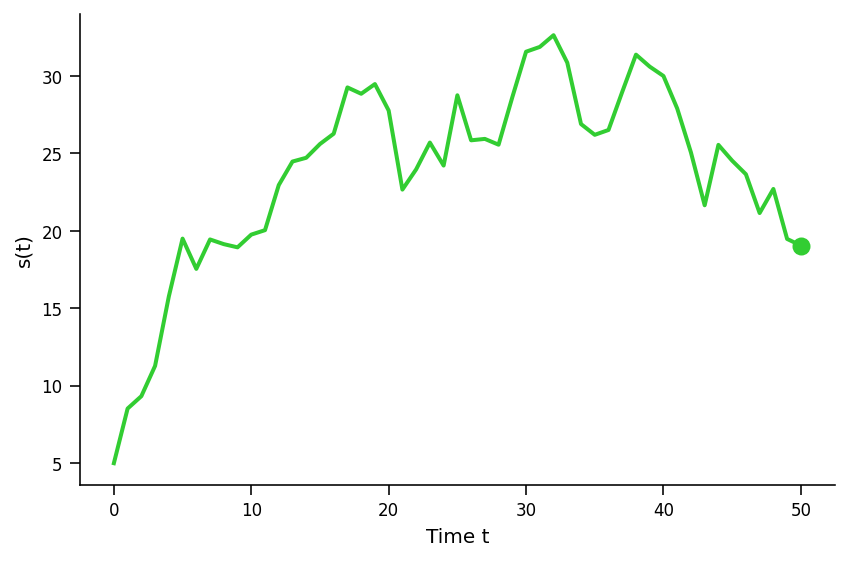

In [31]:
# fixed params
np.random.seed(0)

T_max = 200
D = 1
tau_min = 1
tau_max = 50
process_noise_min = 0.1
process_noise_max = 10
measurement_noise_min = 0.1
measurement_noise_max = 10

unit_process_noise = np.random.randn(T_max)  # compute all N(0, 1) in advance to speed up time slider
unit_measurement_noise = np.random.randn(T_max)  # compute all N(0, 1) in advance to speed up time slider


def simulate(D, s0, sigma_p, T):
    """ Compute the response of the linear dynamical system.

    Args:
        D (scalar): dynamics multiplier
        s0 (scalar): initial position
        sigma_p (scalar): amount of noise in the system (standard deviation)
        T (scalar): total duration of the simulation
    
    Returns:
        ndarray: `s`: astrocat's trajectory up to time T
    """

    # Initialize variables
    s = np.zeros(T+1)
    s[0] = s0

    # Compute the position at time t given the position at time t-1 for all t
    # Consider that np.random.normal(mu, sigma) generates a random sample from
    # a gaussian with mean = mu and standard deviation = sigma

    for t in range(1, len(s)):
        # update position
        s[t] = D*s[t-1] + np.random.normal(0, sigma_p)

    return s


# Set random seed
np.random.seed(0)

# Set parameters
D = 1    # parameter in s(t)
T = 50      # total time duration
s0 = 5.     # initial condition of s at time 0
sigma_p = 2 # amount of noise in the actuators of astrocat's propulsion unit

# Simulate Astrocat
s = simulate(D, s0, sigma_p, T)

# Visualize
visualize_Astrocat(s, T)

Now incorporate noisy measurements. 

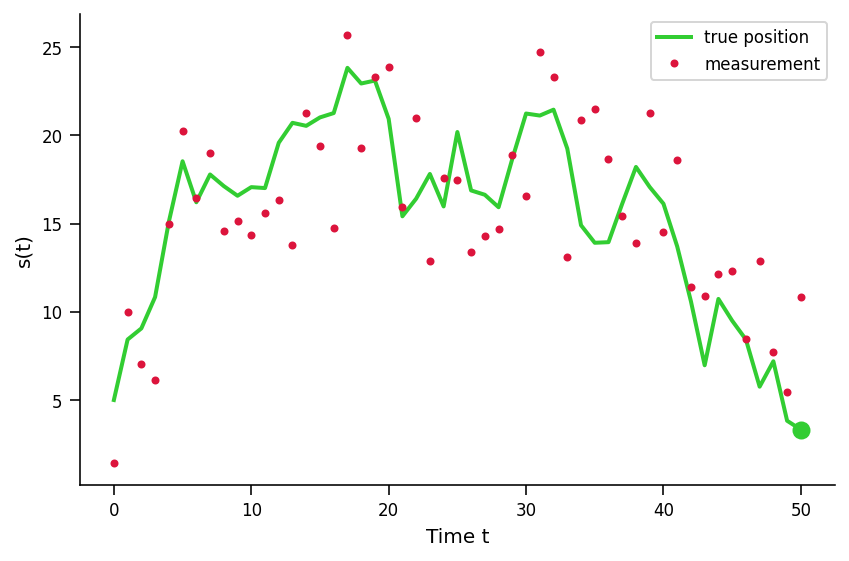

In [34]:
def read_collar(s, sigma_measurements):
    """ Compute the measurements of the noisy sensor attached to astrocat's collar

    Args:
    s (ndarray): astrocat's true position over time
    sigma_measurements (scalar): amount of noise in the sensor (standard deviation)

    Returns:
    ndarray: `m`: astrocat's position over time according to the sensor
    """

    # Initialize variables
    m = np.zeros(len(s))

    # For all time t, add white Gaussian noise with magnitude sigma_measurements
    # Consider that np.random.normal(mu, sigma) generates a random sample from
    # a gaussian with mean = mu and standard deviation = sigma

    for t in range(len(s)):
        # Read measurement
        m[t] = s[t] + np.random.normal(0,sigma_measurements)

    return m


# Set parameters
np.random.seed(0)
D = 0.98    # parameter in s(t)
T = 50      # total time duration
s0 = 5.     # initial condition of s at time 0
sigma_p = 2 # amount of noise in the actuators of astrocat's propulsion unit
sigma_measurements = 4 # amount of noise in astrocat's collar

# Simulate Astrocat
s = simulate(D, s0, sigma_p, T)

# Take measurement from collar
m = read_collar(s, sigma_measurements)

# Visualize
plot_measurement(s, m, T)

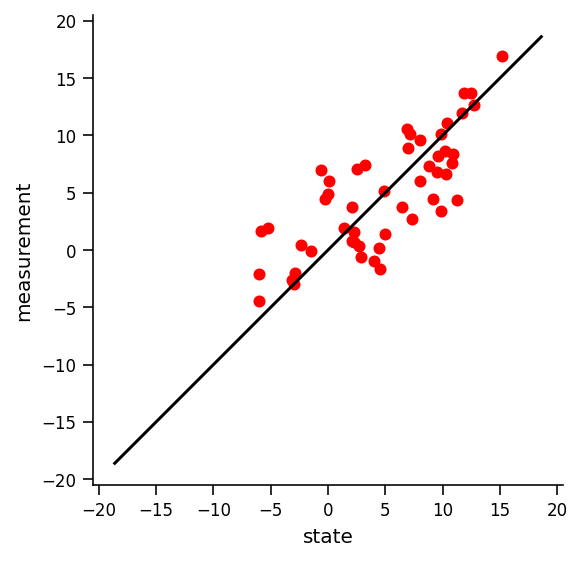

In [35]:
def compare(s, m):
    
    """ Compute a scatter plot

    Args:
    s (ndarray): astrocat's true position over time
    m (ndarray): astrocat's measured position over time according to the sensor

    """
 
    fig = plt.figure()
    ax = fig.add_subplot(111)
    sbounds = 1.1*max(max(np.abs(s)), max(np.abs(m)))
    ax.plot([-sbounds, sbounds], [-sbounds, sbounds], 'k')    # plot line of equality
    ax.set_xlabel('state')
    ax.set_ylabel('measurement')
    ax.set_aspect('equal')

    # Complete a scatter plot: true state versus measurements
    plt.scatter(s, m, marker='.', color='red', s=100)
      


# Set parameters
np.random.seed(0)
D = 0.9    # parameter in s(t)
T = 50      # total time duration
s0 = 5.     # initial condition of s at time 0
sigma_p = 2 # amount of noise in the actuators of astrocat's propulsion unit
sigma_measurements = 4 # amount of noise in astrocat's collar

# Simulate Astrocat
s = simulate(D, s0, sigma_p, T)

# Take measurement from collar
m = read_collar(s, sigma_measurements)

# Visualize true vs measured states
compare(s,m)

In [36]:
# @markdown Execute this cell to enable the demo. It takes a few seconds to update so please be patient.
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(T=widgets.IntSlider(T_max/4, description="current time", min=1, max=T_max-1),
                  tau=widgets.FloatSlider(tau_max/2, description='dynamics time constant', min=tau_min, max=tau_max),
                  process_noise=widgets.FloatSlider(2, description="process noise", min=process_noise_min, max=process_noise_max),
                  measurement_noise=widgets.FloatSlider(3, description="observation noise", min=measurement_noise_min, max=measurement_noise_max),
                  flag_s = widgets.Checkbox(value=True, description='state', disabled=True, indent=False),
                  flag_m = widgets.Checkbox(value=False, description='measurement', disabled=False, indent=False),
                  flag_s_ = widgets.Checkbox(value=False, description='estimate', disabled=False, indent=False),
                  flag_err_ = widgets.Checkbox(value=False, description='estimator confidence intervals', disabled=False, indent=False))

def stochastic_system(T, tau, process_noise, measurement_noise, flag_m, flag_s_, flag_err_):
    t = np.arange(0, T_max, 1)              # timeline
    s = np.zeros(T_max)                     # states
    D = np.exp(-1/tau)                      # dynamics multiplier (matrix if s is vector)
    process_noise_cov = process_noise**2
    measurement_noise_cov = measurement_noise**2

    prior_mean = 0
    prior_cov = process_noise_cov/(1-D**2)

    s[0] = np.sqrt(prior_cov) * unit_process_noise[0]   # Sample initial condition from equilibrium distribution

    m = np.zeros(T_max)    # measurement
    s_ = np.zeros(T_max)    # estimate (posterior mean)
    cov_ = np.zeros(T_max)    # uncertainty (posterior covariance)

    s_[0] = prior_mean
    cov_[0] = prior_cov
    posterior = gaussian(prior_mean, prior_cov)

    captured_prior = None
    captured_likelihood = None
    captured_posterior = None

    onfilter = True
    for i in range(1, T_max):
        s[i] = D * s[i-1] + process_noise * unit_process_noise[i-1]

        if onfilter:
          m[i] = s[i] + measurement_noise * unit_measurement_noise[i]

          prior, likelihood, posterior = filter(D, process_noise_cov, measurement_noise_cov, posterior, m[i])

          s_[i] =  posterior.mean
          cov_[i] = posterior.cov

        if i == T:
          onfilter = False
          captured_prior = prior
          captured_likelihood = likelihood
          captured_posterior = posterior

    smin = min(min(m),min(s-2*np.sqrt(cov_[-1])),min(s_-2*np.sqrt(cov_[-1])))
    smax = max(max(m),max(s+2*np.sqrt(cov_[-1])),max(s_+2*np.sqrt(cov_[-1])))
    pscale = 0.2  # scaling factor for displaying pdfs

    fig = plt.figure(figsize=[15, 10])
    ax = plt.subplot(2, 1, 1)
    ax.set_xlabel('time')
    ax.set_ylabel('state')
    ax.set_xlim([0, T_max+(T_max*pscale)])
    ax.set_ylim([smin, smax])

    show_pdf = [False, False]
    ax.plot(t[:T+1], s[:T+1], color='limegreen', lw=2)
    ax.plot(t[T:], s[T:], color='limegreen', lw=2, alpha=0.3)
    ax.plot([t[T:T+1]], [s[T:T+1]], marker='o', markersize=8, color='limegreen')

    if flag_m:
        ax.plot(t[:T+1], m[:T+1], '.', color='crimson', lw=2)
        ax.plot([t[T:T+1]], [m[T:T+1]], marker='o', markersize=8, color='crimson')

        domain = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 500)
        pdf_likelihood = norm.pdf(domain, captured_likelihood.mean, np.sqrt(captured_likelihood.cov))
        ax.fill_betweenx(domain, T + pdf_likelihood*(T_max*pscale), T, color='crimson', alpha=0.5, label='likelihood', edgecolor="crimson", linewidth=0)
        ax.plot(T + pdf_likelihood*(T_max*pscale), domain, color='crimson', linewidth=2.0)

        ax.legend(ncol=3, loc='upper left')
        show_pdf[0] = True

    if flag_s_:
        ax.plot(t[:T+1], s_[:T+1], color='black', lw=2)
        ax.plot([t[T:T+1]], [s_[T:T+1]], marker='o', markersize=8, color='black')
        show_pdf[1] = True

    if flag_err_:
        ax.fill_between(t[:T+1], s_[:T+1] + 2 * np.sqrt(cov_)[:T+1], s_[:T+1] - 2 * np.sqrt(cov_)[:T+1], color='black', alpha=0.3)
        show_pdf[1] = True

    if show_pdf[1]:
        domain = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 500)
        pdf_post = norm.pdf(domain, captured_posterior.mean, np.sqrt(captured_posterior.cov))
        ax.fill_betweenx(domain, T + pdf_post*(T_max*pscale), T, color='black', alpha=0.5, label='posterior', edgecolor="black", linewidth=0)
        ax.plot(T + pdf_post*(T_max*pscale), domain, color='black', linewidth=2.0)
        ax.legend(ncol=3, loc='upper left')

    if show_pdf[0] and show_pdf[1]:
        domain = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 500)
        pdf_prior = norm.pdf(domain, captured_prior.mean, np.sqrt(captured_prior.cov))
        ax.fill_betweenx(domain, T + pdf_prior*(T_max*pscale), T, color='dodgerblue', alpha=0.5, label='prior', edgecolor="dodgerblue", linewidth=0)
        ax.plot(T + pdf_prior*(T_max*pscale), domain, color='dodgerblue', linewidth=2.0)
        ax.legend(ncol=3, loc='upper left')

plt.show()

interactive(children=(IntSlider(value=50, description='current time', max=199, min=1), FloatSlider(value=25.0,…

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


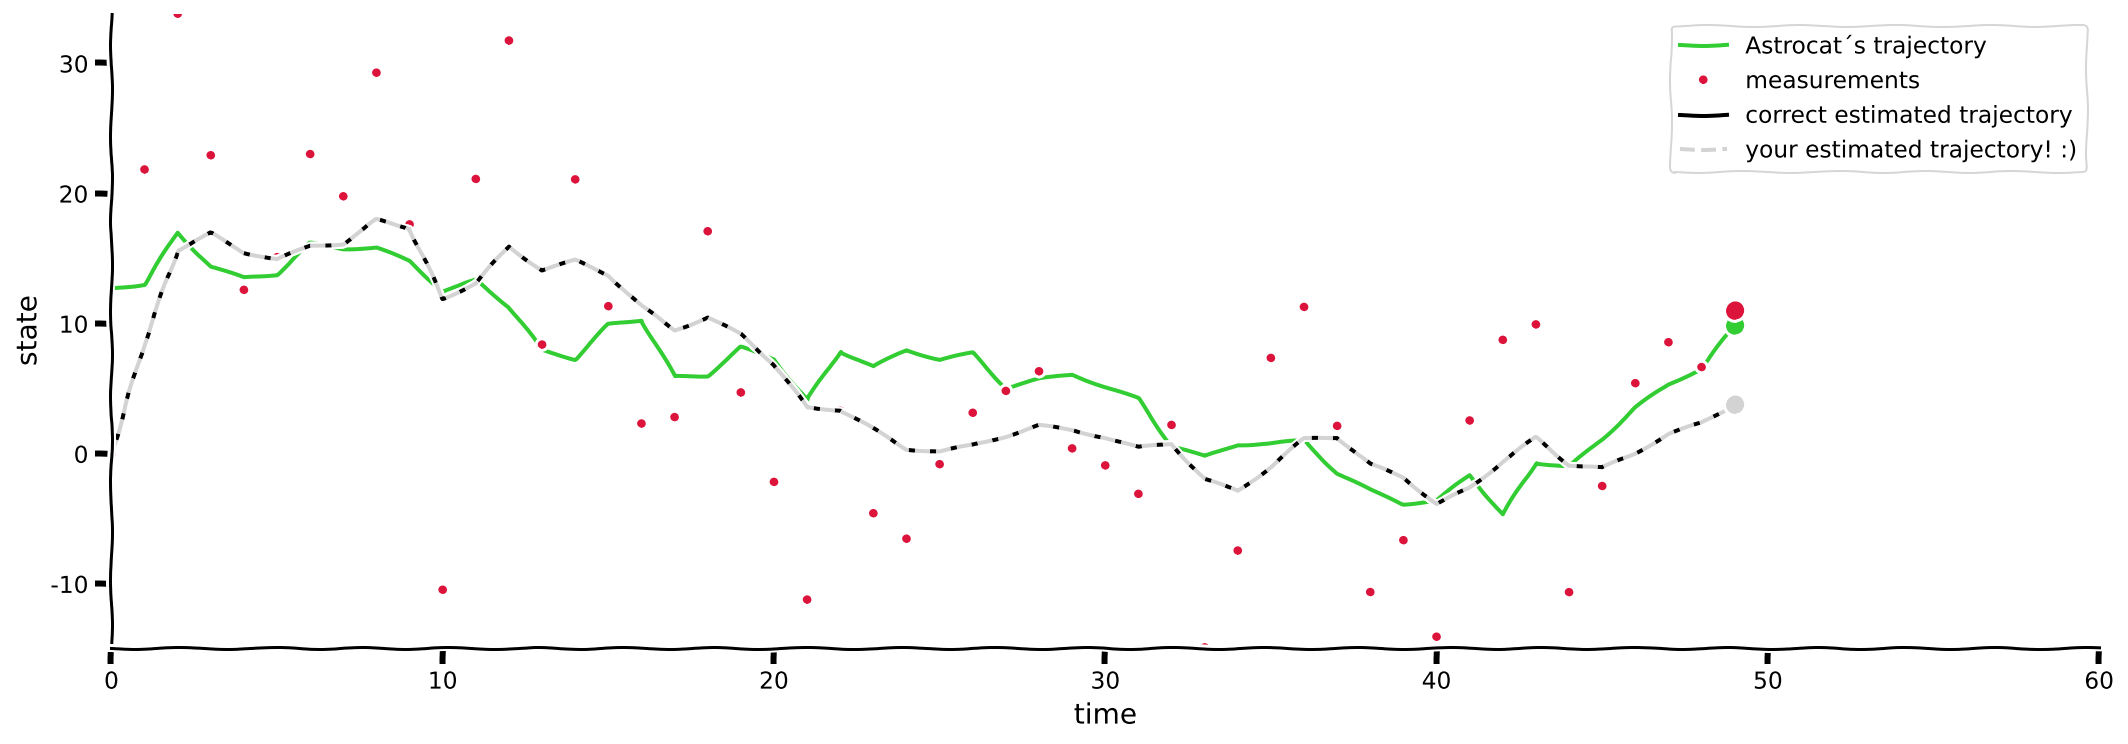

In [37]:
# Set random seed
np.random.seed(0)

# Set parameters
T = 50                  # Time duration
tau = 25                # dynamics time constant
process_noise = 2       # process noise in Astrocat's propulsion unit (standard deviation)
measurement_noise = 9   # measurement noise in Astrocat's collar (standard deviation)

# Auxiliary variables
process_noise_cov = process_noise**2          # process noise in Astrocat's propulsion unit (variance)
measurement_noise_cov = measurement_noise**2  # measurement noise in Astrocat's collar (variance)

# Initialize arrays
t = np.arange(0, T, 1)   # timeline
s = np.zeros(T)          # states
D = np.exp(-1/tau)       # dynamics multiplier (matrix if s is vector)

m = np.zeros(T)          # measurement
s_ = np.zeros(T)         # estimate (posterior mean)
cov_ = np.zeros(T)       # uncertainty (posterior covariance)

# Initial guess of the posterior at time 0
initial_guess = gaussian(0, process_noise_cov/(1-D**2))    # In this case, the initial guess (posterior distribution
                                                           # at time 0) is the equilibrium distribution, but feel free to
                                                           # experiment with other gaussians
posterior = initial_guess

# Sample initial conditions
s[0] = posterior.mean + np.sqrt(posterior.cov) * np.random.randn()   # Sample initial condition from posterior distribution at time 0
s_[0] = posterior.mean
cov_[0] = posterior.cov

# Loop over steps
for i in range(1, T):

  # Sample true states and corresponding measurements
  s[i] = D * s[i-1] + np.random.normal(0, process_noise)    # variable `s` records the true position of Astrocat
  m[i] = s[i] + np.random.normal(0, measurement_noise)      # variable `m` records the measurements of Astrocat's collar

  # Step 1. Shift yesterday's posterior to match the deterministic change of the system's dynamics,
  #         and broad it to account for the random change (i.e., add mean and variance of process noise).
  todays_prior = gaussian(D * posterior.mean, D**2 * posterior.cov + process_noise_cov)

  # Step 2. Now that yesterday's posterior has become today's prior, integrate new evidence
  #         (i.e., multiply gaussians from today's prior and likelihood)
  likelihood = gaussian(m[i], measurement_noise_cov)

  # Step 2a:  To find the posterior variance, add informations (inverse variances) of prior and likelihood
  info_prior = 1/todays_prior.cov
  info_likelihood = 1/likelihood.cov
  info_posterior = info_prior + info_likelihood

  # Step 2b: To find the posterior mean, calculate a weighted average of means from prior and likelihood;
  #          the weights are just the fraction of information that each gaussian provides!
  prior_weight = info_prior / info_posterior
  likelihood_weight = info_likelihood / info_posterior
  posterior_mean = prior_weight * todays_prior.mean  +  likelihood_weight * likelihood.mean

  # Don't forget to convert back posterior information to posterior variance!
  posterior_cov = 1/info_posterior
  posterior = gaussian(posterior_mean, posterior_cov)

  s_[i] = posterior.mean
  cov_[i] = posterior.cov

# Visualize
with plt.xkcd():
  paintMyFilter(D, initial_guess, process_noise_cov, measurement_noise_cov, s, m, s_, cov_)